In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/208.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/473.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/333.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/45.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/369.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/56.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/89.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/20.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/275.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/212.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/239.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/58.jpg
/kaggle/input/cityscapes-image-pa

In [1]:
import os
path=os.listdir("/kaggle/input/blurryviz/BlurryViz")
print(path)
path2=os.listdir("/kaggle/input/cityscapes-image-pairs")
print(path2)

['valid', 'DeBlur', 'test', 'train']
['cityscapes_data']


In [174]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision import models
from torchsummary import summary
from tqdm.notebook import tqdm
from skimage.metrics import structural_similarity as ssim

In [175]:
# Define image size
IMAGE_SIZE = [256, 256]
IMAGE_SHAPE = IMAGE_SIZE + [3]
train_filepath_blur = '/kaggle/input/blurryviz/BlurryViz/DeBlur/train'
train_filepath_clean='/kaggle/input/blurryviz/BlurryViz/train'
val_filepath_blur = '/kaggle/input/blurryviz/BlurryViz/DeBlur/valid'
val_filepath_clean='/kaggle/input/blurryviz/BlurryViz/valid'

In [176]:
def image_work(filename,image_size):
     image = Image.open(filename)
     image = image.resize(image_size)
     image = np.array(image) / 255 
    
     return image


In [177]:
from PIL import Image
import numpy as np
train_images_blur=[]
train_images_clean=[]
val_images_blur=[]
val_images_clean=[]

for train_file_blur in tqdm(os.listdir(train_filepath_blur), desc="Building blurring Dataset:"):
    img_path = image_work(os.path.join(train_filepath_blur, train_file_blur),IMAGE_SIZE)
    train_images_blur.append(img_path)

for train_file_clean in tqdm(os.listdir(train_filepath_clean), desc="Building clean dataset:"):
    img_path = image_work(os.path.join(train_filepath_clean, train_file_clean),IMAGE_SIZE)
    train_images_clean.append(img_path)
for val_file_blur in tqdm(os.listdir(val_filepath_blur),desc="Building blur val dataset:"):
    val_path=image_work(os.path.join(val_filepath_blur,val_file_blur),IMAGE_SIZE)
    val_images_blur.append(val_path)
for val_file_clean in tqdm(os.listdir(val_filepath_blur),desc="building clean val dataset:"):
    val_path=image_work(os.path.join(val_filepath_clean,val_file_clean),IMAGE_SIZE)
    val_images_clean.append(val_path)
    


Building blurring Dataset::   0%|          | 0/493 [00:00<?, ?it/s]

Building clean dataset::   0%|          | 0/493 [00:00<?, ?it/s]

Building blur val dataset::   0%|          | 0/140 [00:00<?, ?it/s]

building clean val dataset::   0%|          | 0/140 [00:00<?, ?it/s]

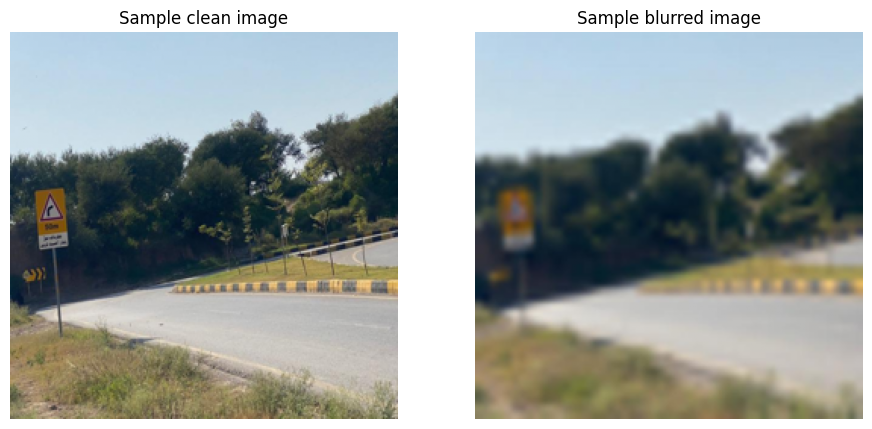

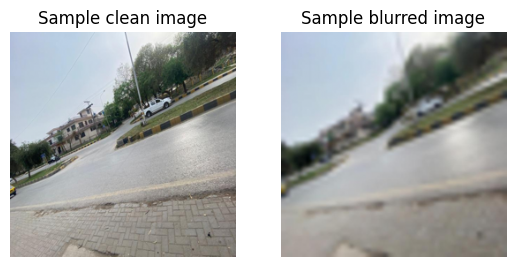

In [178]:
# Visualize samples
plt.figure(figsize=[11, 6])
for i in range(2):
    img = train_images_clean[i]
    blur_img = train_images_blur[i]
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample clean image')

    plt.subplot(1, 2, 2)
    plt.imshow(blur_img)
    plt.axis('off')
    plt.title('Sample blurred image')
    plt.show()


In [179]:
# Convert lists to numpy arrays
train_images_blur = np.stack(train_images_blur).astype("float32")
train_images_clean = np.stack(train_images_clean).astype("float32")
val_images_blur = np.stack(val_images_blur).astype("float32")
val_images_clean = np.stack(val_images_clean).astype("float32")


In [199]:

class DoubleConvBlur(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlur, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU( inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        

    def forward(self, x):
        return self.conv(x)


class Deblurring(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512,1024]):
        super(Deblurring, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling part
        for feature in features:
            self.downs.append(DoubleConvBlur(in_channels, feature))
            in_channels = feature

        # Upsampling part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConvBlur(feature * 2, feature))

        # Bottleneck and final layer
        self.bottleneck = DoubleConvBlur(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [193]:
from torch.utils.data import Dataset
import torch

class CustomTrainData(Dataset):
    def __init__(self, blur_images, clean_images, transform=None):
        self.blur_images = blur_images
        self.clean_images = clean_images
        self.transform = transform
        print(f"Total valid images: {len(self.blur_images)}")

    def __len__(self):
        return len(self.blur_images)

    def __getitem__(self, idx):
        clean_image = self.clean_images[idx]
        blurred_image = self.blur_images[idx]

        clean_image = torch.tensor(clean_image).permute(2, 0, 1).float()
        blurred_image = torch.tensor(blurred_image).permute(2, 0, 1).float()

        if self.transform:
            clean_image = self.transform(clean_image)
            blurred_image = self.transform(blurred_image)

        return blurred_image, clean_image


In [194]:
from torch.utils.data import DataLoader
train_dataset = CustomTrainData(train_images_blur, train_images_clean)
val_dataset = CustomTrainData(val_images_blur,val_images_clean)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
for blurred_image,clean_image in train_loader:
  print("Train batch-blur images shape:",blurred_image.shape)
  print("Train batch-clean image shape:",clean_image.shape)
  break
for blurred_image,clean_image in val_loader:
    print("Train batch-blur image shape:",blurred_image.shape)
    print("Train batch-clean image shape:",clean_image.shape)
    break

Total valid images: 493
Total valid images: 140
Train batch-blur images shape: torch.Size([4, 3, 256, 256])
Train batch-clean image shape: torch.Size([4, 3, 256, 256])
Train batch-blur image shape: torch.Size([4, 3, 256, 256])
Train batch-clean image shape: torch.Size([4, 3, 256, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

deblur_model = Deblurring(in_channels=3, out_channels=3).to(device)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(deblur_model.parameters(), lr=1e-4)

# Add learning rate scheduler (based on validation loss)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 30

for epoch in range(num_epochs):
    torch.cuda.empty_cache()  
    deblur_model.train()
    running_loss = 0.0
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for blurred_img, clean_img in train_loader_tqdm:
        clean_img = clean_img.to(device)
        blurred_img = blurred_img.to(device)

        optimizer.zero_grad()
        output = deblur_model(blurred_img)
        loss = loss_fn(output, clean_img)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    deblur_model.eval()
    val_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for clean_img, blurred_img in val_loader_tqdm:
            clean_img = clean_img.to(device)
            blurred_img = blurred_img.to(device)

            output = deblur_model(blurred_img)
            loss = loss_fn(output, clean_img)
            val_loss += loss.item()
            val_loader_tqdm.set_postfix(val_loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] ➤ Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Step the scheduler using validation loss
    scheduler.step(avg_val_loss)



Epoch [1/30]


Epoch [1/30] ➤ Train Loss: 0.1049 | Val Loss: 0.0677

Epoch [2/30]


Epoch [2/30] ➤ Train Loss: 0.0513 | Val Loss: 0.0573

Epoch [3/30]


Training:  63%|██████▎   | 78/124 [00:27<00:16,  2.87it/s, loss=0.0416]

In [141]:
# Load test data
test_filepath_blur = '/kaggle/input/blurryviz/BlurryViz/DeBlur/test'
test_filepath_clean='/kaggle/input/blurryviz/BlurryViz/test'
test_images_blur = []
test_images_clean = []
import os
from PIL import Image

def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
for file in tqdm(os.listdir(test_filepath_clean), desc="loading clean test images"):
    if is_image_file(file):
        clean_image = image_work(os.path.join(test_filepath_clean, file), IMAGE_SIZE)
        test_images_clean.append(clean_image)    
for file in tqdm(os.listdir(test_filepath_blur), desc="Loading blur test images"):
    if is_image_file(file):
       blur_image= image_work(os.path.join(test_filepath_blur, file), IMAGE_SIZE)
       test_images_blur.append(blur_image)

    

test_images_clean = np.stack(test_images_clean).astype('float32')
test_images_blur=np.stack(test_images_blur).astype('float32')

Loading blur test images: 100%|██████████| 74/74 [00:00<00:00, 124.63it/s]


In [142]:

class CustomTestDataset(Dataset):
    def __init__(self, test_blur, test_clean, transform=None):
        self.test_blur = test_blur
        self.test_clean = test_clean
        self.transform = transform
        print(f"Total test images: {len(self.test_blur)}")

    def __len__(self):
        return len(self.test_blur)

    def __getitem__(self, idx):
        test_blur = self.test_blur[idx]
        test_clean = self.test_clean[idx]

        test_blur = torch.tensor(test_blur).permute(2, 0, 1).float()
        test_clean = torch.tensor(test_clean).permute(2, 0, 1).float()

        if self.transform:
            test_blur = self.transform(test_blur)
            test_clean = self.transform(test_clean)

        return test_blur, test_clean


In [143]:
test_dataset_blur = CustomTestDataset(test_images_blur,test_images_clean)
test_loader_blur = DataLoader(test_dataset_blur, batch_size=6, shuffle=True)


Total test images: 74


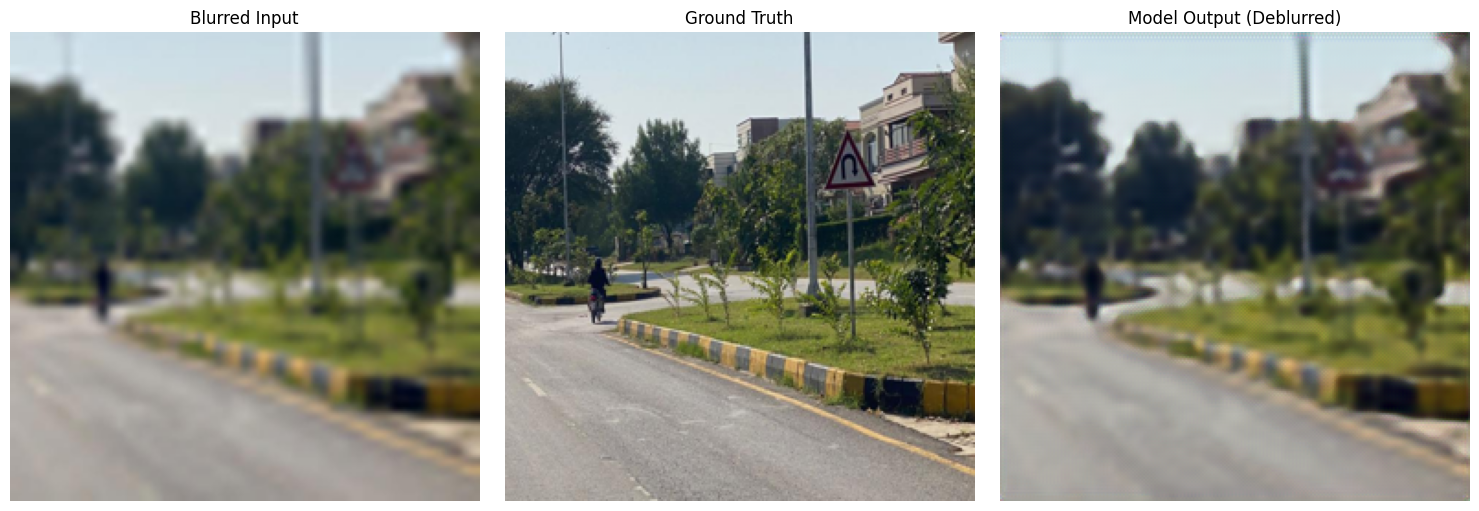

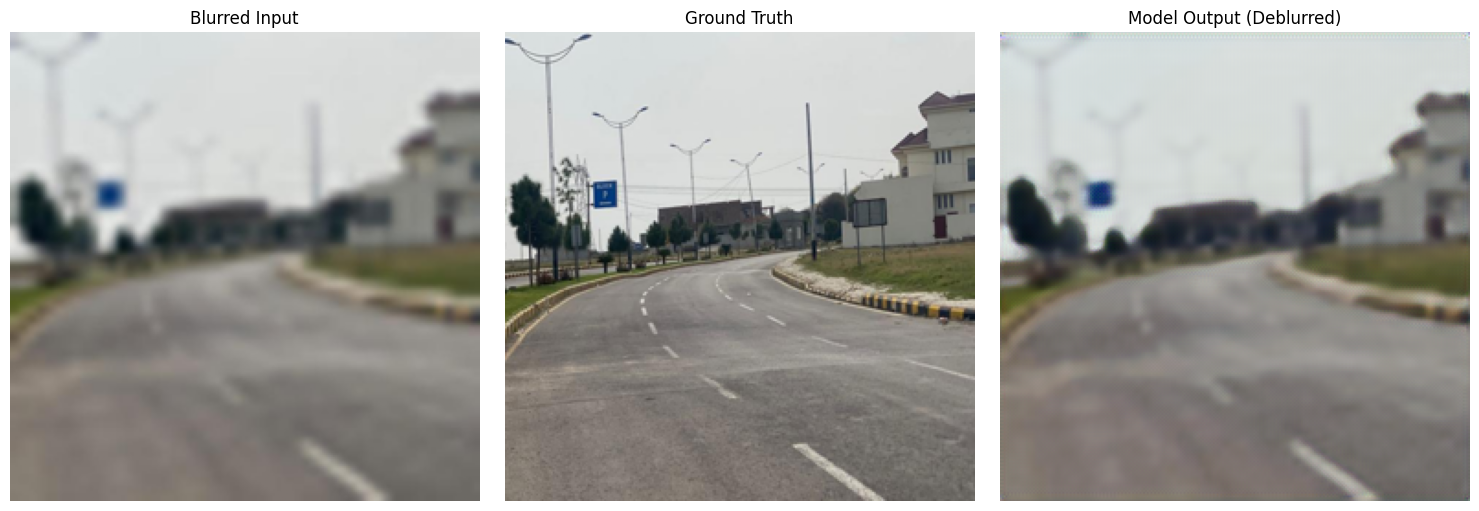

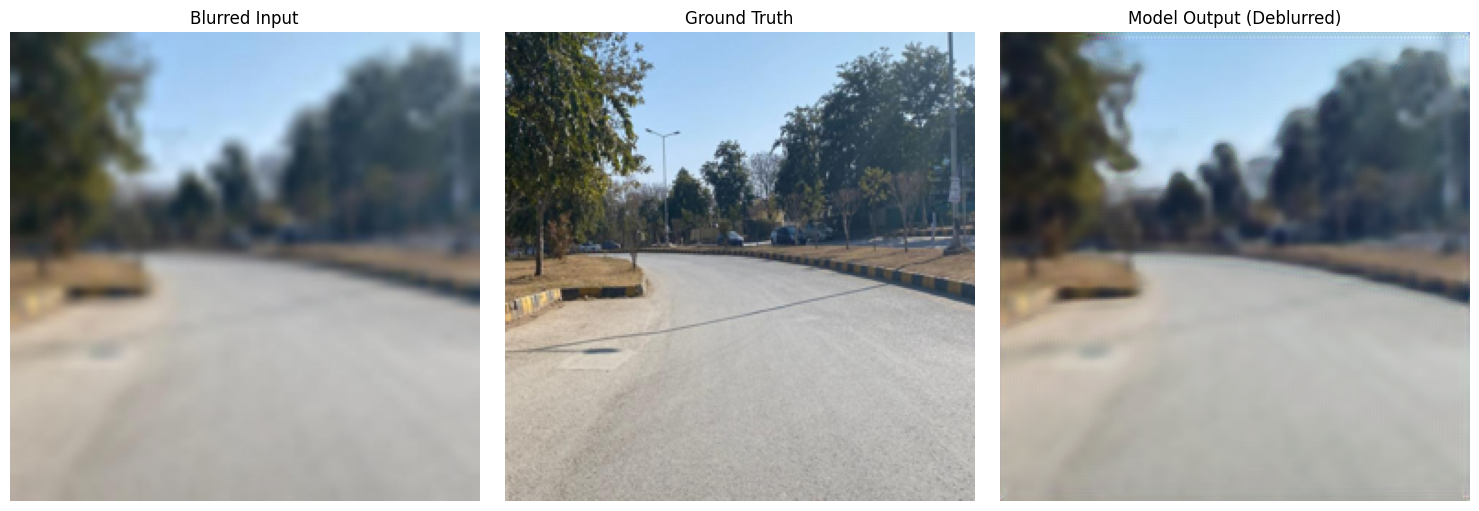

In [201]:
import os
import torch
import matplotlib.pyplot as plt

save_dir = "/kaggle/working/deblurred_outputs"
os.makedirs(save_dir, exist_ok=True)

deblur_model.eval()
with torch.no_grad():
    for batch_idx, (blurred_image, clean_image) in enumerate(test_loader_blur):
        blurred_image = blurred_image.to(device)
        clean_image = clean_image.to(device)

        outputs = deblur_model(blurred_image)  # <- Use the correct variable name

        # Save all outputs to .pt files
        for i, output in enumerate(outputs):
            file_path = os.path.join(save_dir, f"deblurred_{batch_idx}_{i}.pt")
            torch.save(output.cpu(), file_path)

        if batch_idx == 0:
            # Just for display
            blurred_image = blurred_image.cpu()
            clean_image = clean_image.cpu()
            outputs = outputs.cpu()

            for i in range(min(3, len(blurred_image))):
                blur_img = blurred_image[i].permute(1, 2, 0).numpy().clip(0, 1)
                true_img = clean_image[i].permute(1, 2, 0).numpy().clip(0, 1)
                pred_img = outputs[i].permute(1, 2, 0).numpy().clip(0, 1)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(blur_img)
                plt.title("Blurred Input")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(true_img)
                plt.title("Ground Truth")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_img)
                plt.title("Model Output (Deblurred)")
                plt.axis('off')

                plt.tight_layout()
                plt.show()


In [145]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision import models
from torchsummary import summary
from tqdm.notebook import tqdm

In [147]:
labels = [
    ['road', 'flat', [128, 64, 128]],
    ['sidewalk', 'flat', [244, 35, 232]],
    ['building', 'construction', [70, 70, 70]],
    ['wall', 'construction', [102, 102, 156]],
    ['fence', 'construction', [190, 153, 153]],
    ['pole', 'object', [153, 153, 153]],
    ['traffic light', 'object', [250, 170, 30]],
    ['traffic sign', 'object', [220, 220, 0]],
    ['vegetation', 'nature', [107, 142, 35]],
    ['terrain', 'nature', [152, 251, 152]],
    ['sky', 'sky', [70, 130, 180]],
    ['person', 'human', [220, 20, 60]],
    ['rider', 'human', [255, 0, 0]],
    ['car', 'vehicle', [0, 0, 142]],
    ['truck', 'vehicle', [0, 0, 70]],
    ['bus', 'vehicle', [0, 60, 100]],
    ['train', 'vehicle', [0, 80, 100]],
    ['motorcycle', 'vehicle', [0, 0, 230]],
    ['bicycle', 'vehicle', [119, 11, 32]],
]
id2color = {i: np.array(label[2]) for i, label in enumerate(labels)}
color2trainId = {tuple(label[2]): i for i, label in enumerate(labels)}


In [149]:
data_dir = os.path.join("/kaggle","input","cityscapes-image-pairs","cityscapes_data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg


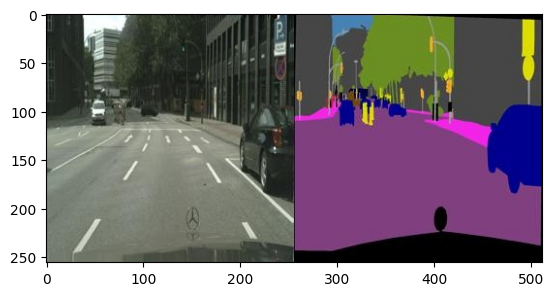

In [150]:
sample_image_show = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_show).convert("RGB")
plt.imshow(sample_image)
print(sample_image_show)

In [151]:
def find_closest_labels_vectorized(mask, color2trainId):
    closest_distance = np.full((mask.shape[0], mask.shape[1]), 1e6)
    closest_category = np.full((mask.shape[0], mask.shape[1]), 255)

    for color, trainId in color2trainId.items():
        color = np.array(color)
        dist = np.linalg.norm(mask - color.reshape((1, 1, 3)), axis=-1)
        is_closer = dist < closest_distance
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, trainId, closest_category)

    return closest_category

In [153]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

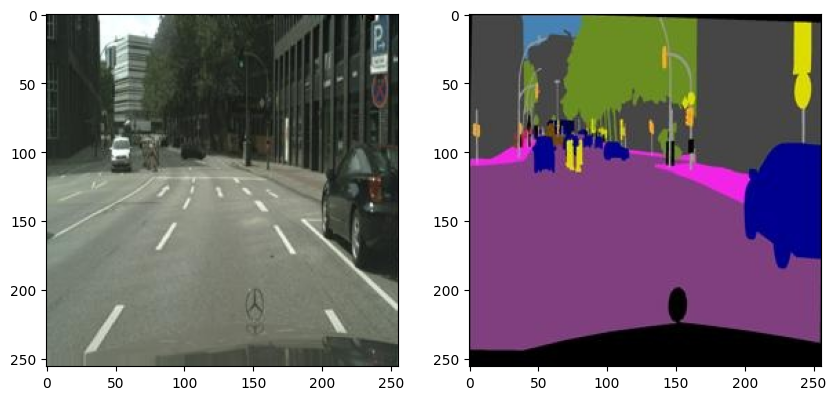

In [154]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [155]:
IMAGE_SIZE = [256, 256]
IMAGE_SHAPE = IMAGE_SIZE + [3,]

In [157]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 
    mask = np.array(mask)
    
    return image, mask


In [158]:
train_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
# val_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'
train_images = [] 
train_masks = []
train_masks_enc = []
# val_images = []
# val_masks = []
# val_masks_enc = []

for train_file in tqdm(os.listdir(train_filepath), desc = 'Building Training Dataset: '):
    image, mask = image_mask_split(train_filepath + train_file, IMAGE_SIZE)
    train_images.append(image)
    train_masks.append(mask)
    train_masks_enc.append(find_closest_labels_vectorized(mask, color2trainId))
    
# for val_file in tqdm(os.listdir(val_filepath), desc = 'Building Validation Dataset: '):
#     image, mask = image_mask_split(val_filepath + val_file, IMAGE_SIZE)
#     val_images.append(image)
#     val_masks.append(mask)
#     val_masks_enc.append(find_closest_labels_vectorized(mask, color2trainId))

Building Training Dataset:   0%|          | 0/2975 [00:00<?, ?it/s]

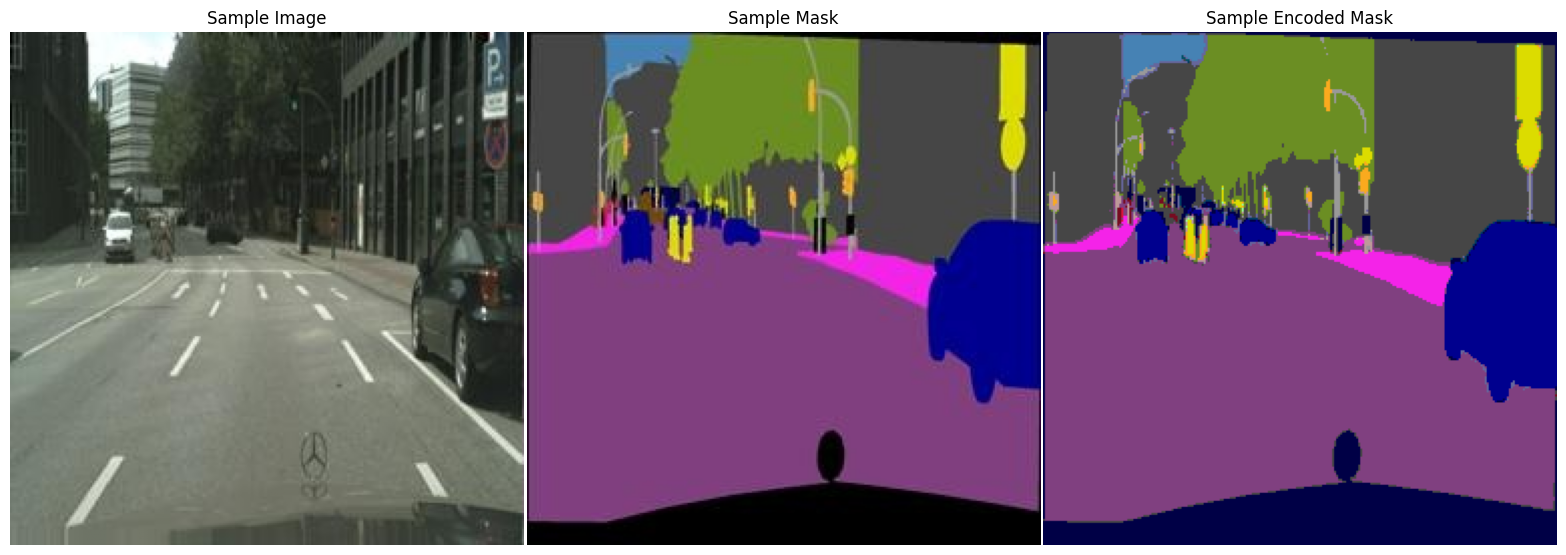

In [160]:
plt.figure(figsize=[20, 14])

for i in range(1):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]  # Should be shape [H, W], with trainIds (0–18)

    tmp = np.zeros([enc.shape[0], enc.shape[1], 3], dtype=np.uint8)

    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[int(enc[row, col])]

    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample Image')

    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.title('Sample Mask')

    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.title('Sample Encoded Mask')

plt.subplots_adjust(wspace=0, hspace=0.1)


In [161]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

# val_images = np.stack(val_images).astype('float32')
# val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [162]:
unique_vals = np.unique(train_masks_enc)
print("Unique mask labels:", unique_vals)

Unique mask labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18.]


In [163]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.se = SEBlock(out_channels) 

    def forward(self, x):
        x = self.conv(x)
        return self.se(x)

class Segmentation(nn.Module):
    def __init__(self, in_channels=3, out_channels=19, features=[64, 128, 256, 512]):
        super(Segmentation, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [164]:
class CustomTrainDataset(Dataset):
    def __init__(self, images, masks_enc, transform=None):
        self.images = images
        self.masks_enc = masks_enc
        self.transform = transform
        print(f"Total valid images: {len(self.images)}")
        print(f"total valid mask:{len(self.masks_enc)}")

    def __len__(self):
        return len(self.images)
        

    def __getitem__(self, idx):
        image = self.images[idx]
        mask_enc = self.masks_enc[idx]

       
        image = torch.tensor(image).permute(2, 0, 1).float()  
        mask_enc = torch.tensor(mask_enc).long()  

        if self.transform:
            image = self.transform(image)
            mask_enc = self.transform(mask_enc)

        return image, mask_enc



In [165]:
from torch.utils.data import DataLoader
train_dataset = CustomTrainDataset(train_images, train_masks_enc)
# val_dataset = CustomTrainDataset(val_images, val_masks_enc)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
for image,mask_enc in train_loader:
  print("Train batch-Clean images shape:",image.shape)
  print("Train batch-Mask shape:",mask_enc.shape)
  break
# for image, mask_enc in val_loader:
#   print("Val batch - Clean images shape:", image.shape)
#   print("Val batch - Mask shape:", mask_enc.shape)
#   break


Total valid images: 2975
total valid mask:2975
Train batch-Clean images shape: torch.Size([8, 3, 256, 256])
Train batch-Mask shape: torch.Size([8, 256, 256])


In [166]:
def sanitize_mask_labels(mask):
    # Torch tensors don't have .copy(), and we want to avoid modifying in-place
    mask = mask.clone()  # use .clone() for torch tensors
    mask[mask > 19] = 255
    return mask


In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Correct import

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seg_model = Segmentation(in_channels=3, out_channels=19).to(device)

lossc = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(seg_model.parameters(), lr=1e-4)

num_epochs = 50

for epoch in range(num_epochs):
    seg_model.train()
    running_loss = 0.0

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for clean, mask in train_loader_tqdm:
        clean = clean.to(device)
        mask=sanitize_mask_labels(mask).to(device)

        optimizer.zero_grad()
        output = seg_model(clean)
        loss = lossc(output, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

 
    print(f"Epoch [{epoch+1}/{num_epochs}] ➤ Train Loss: {avg_train_loss:.4f} ")



Epoch [1/50]


Epoch [1/50] ➤ Train Loss: 1.9986 

Epoch [2/50]


Epoch [2/50] ➤ Train Loss: 1.2179 

Epoch [3/50]


Epoch [3/50] ➤ Train Loss: 0.9175 

Epoch [4/50]


Epoch [4/50] ➤ Train Loss: 0.7999 

Epoch [5/50]


Epoch [5/50] ➤ Train Loss: 0.7390 

Epoch [6/50]


Epoch [6/50] ➤ Train Loss: 0.6948 

Epoch [7/50]


Epoch [7/50] ➤ Train Loss: 0.6656 

Epoch [8/50]


Epoch [8/50] ➤ Train Loss: 0.6427 

Epoch [9/50]


Epoch [9/50] ➤ Train Loss: 0.6192 

Epoch [10/50]


Epoch [10/50] ➤ Train Loss: 0.6060 

Epoch [11/50]


Epoch [11/50] ➤ Train Loss: 0.5919 

Epoch [12/50]


Epoch [12/50] ➤ Train Loss: 0.5750 

Epoch [13/50]


Epoch [13/50] ➤ Train Loss: 0.5644 

Epoch [14/50]


Epoch [14/50] ➤ Train Loss: 0.5524 

Epoch [15/50]


Epoch [15/50] ➤ Train Loss: 0.5391 

Epoch [16/50]


Epoch [16/50] ➤ Train Loss: 0.5338 

Epoch [17/50]


Epoch [17/50] ➤ Train Loss: 0.5221 

Epoch [18/50]


Epoch [18/50] ➤ Train Loss: 0.5101 

Epoch [19/50]


Epoch [19/50] ➤ Train Loss: 0.5018 

Epoch [20/50]


Epoch [20/50] ➤ Train Loss: 0.4938 

Epoch [21/50]


Epoch [21/50] ➤ Train Loss: 0.4854 

Epoch [22/50]


Epoch [22/50] ➤ Train Loss: 0.4770 

Epoch [23/50]


Epoch [23/50] ➤ Train Loss: 0.4713 

Epoch [24/50]


Epoch [24/50] ➤ Train Loss: 0.4636 

Epoch [25/50]


Epoch [25/50] ➤ Train Loss: 0.4572 

Epoch [26/50]


Epoch [26/50] ➤ Train Loss: 0.4493 

Epoch [27/50]


Epoch [27/50] ➤ Train Loss: 0.4445 

Epoch [28/50]


Epoch [28/50] ➤ Train Loss: 0.4364 

Epoch [29/50]


Epoch [29/50] ➤ Train Loss: 0.4352 

Epoch [30/50]


Epoch [30/50] ➤ Train Loss: 0.4256 

Epoch [31/50]


Epoch [31/50] ➤ Train Loss: 0.4214 

Epoch [32/50]


Epoch [32/50] ➤ Train Loss: 0.4146 

Epoch [33/50]


KeyboardInterrupt: 

In [168]:
from torch.utils.data import Dataset
import os
import torch
class DeblurredImageDataset(Dataset):
    def __init__(self,folder_path,transform=None):
        self.folder_path=folder_path
        self.file_list=sorted([f for f in os.listdir(folder_path) if f.endswith(".pt")])
        self.transform=transform
        print(f"total deblurred images found:{len(self.file_list)}")
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self,idx):
        file_path=os.path.join(self.folder_path,self.file_list[idx])
        image=torch.load(file_path)
        if self.transform:
            image=self.transform(image)
        return image


In [202]:
deblurred_dataset=DeblurredImageDataset("/kaggle/working/deblurred_outputs/")
deblurred_loader=DataLoader(deblurred_dataset,batch_size=8,shuffle=False)

total deblurred images found:74


/tmp/ipykernel_31/3127021266.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(file_path)


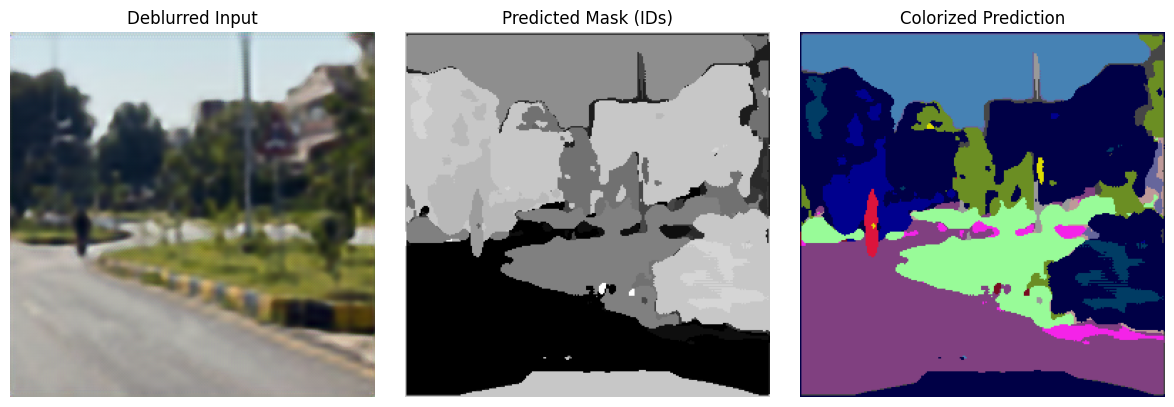

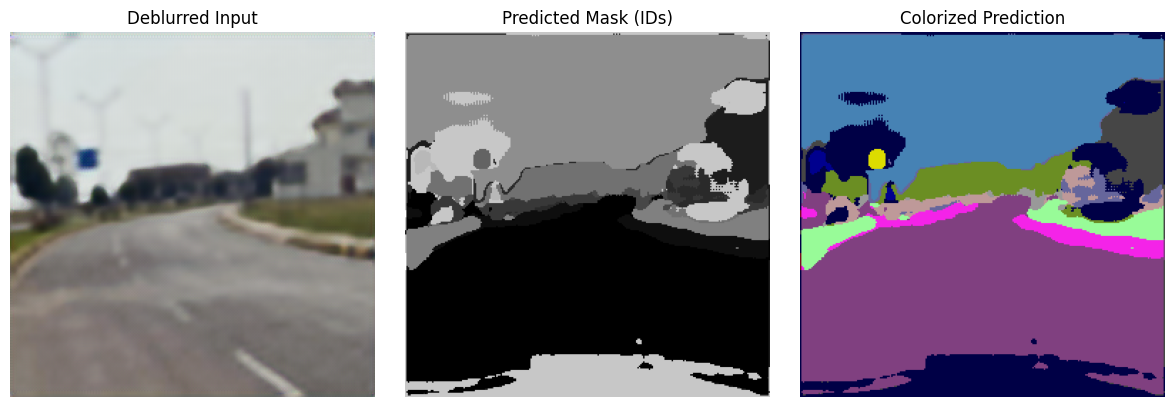

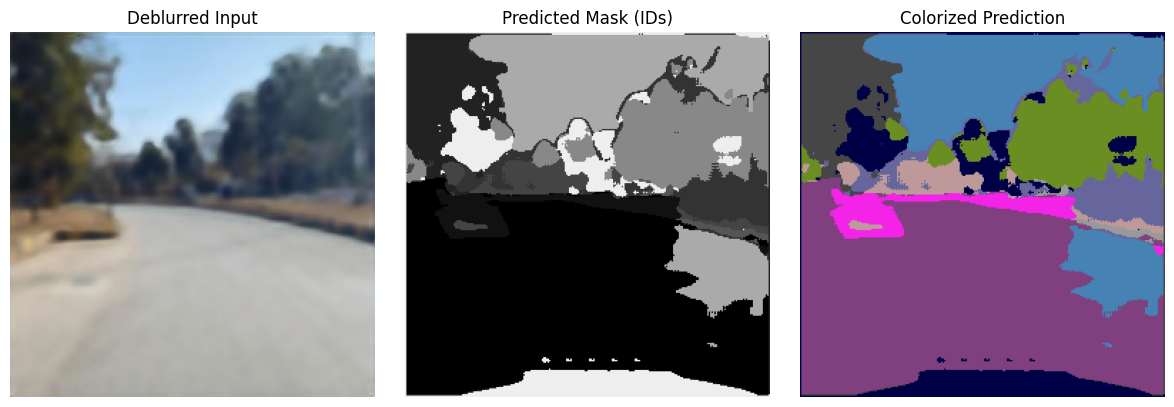

In [203]:
def decode_pred_mask(mask_tensor):
    mask_np = mask_tensor.cpu().numpy()
    h, w = mask_np.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for id, color in id2color.items():
        color_mask[mask_np == id] = color
    return color_mask

seg_model.eval()
with torch.no_grad():
    for image in deblurred_loader:
        image = image.to(device)
        outputs = seg_model(image)  # ✅ use 'image' here
        preds = torch.argmax(outputs, dim=1)

        for i in range(min(3, len(image))):
            input_img = image[i].cpu().permute(1, 2, 0).numpy().clip(0, 1)  # ✅ use 'image' here
            pred_mask = preds[i]
            color_mask = decode_pred_mask(pred_mask)

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(input_img)
            plt.title("Deblurred Input")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred_mask.cpu(), cmap='gray')
            plt.title("Predicted Mask (IDs)")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(color_mask)
            plt.title("Colorized Prediction")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        break  # remove this line if you want to visualize the entire dataset
